# Дорогой дневник

--------------------------------------------

1) Сначала я решил попробовать без генерации новых фичей и без подкрутки параметров запустить LightGBM и посмотреть, что будет. Скор 0.720
При этом пока еще нет ни генерации новых признаков, ни использования таблицы поиска и тд. Попробуем добавить.

2) Просто запускаем код из "baseline_1_pandas.ipynb" и получаем обещаный скор 0.817

3) Оптюнил 10 минут, безрезультатно. Буду придумывать новые признаки. Думаю начать с кластеризации и knn. 

4) Сначала решил просто расширить плавающее окно с 4 до 5 месяцев, результат 0.8192.

    Есть огромное количество идей, только что заменил пандас на поларс, потому что он реально на порядок быстрее. В первую очередь хочется применить знания с семинара по интерпретации бустингов, но сначала заменить катбуст на lgbm, ибо Илья утверждал, что при должном обращении он рвет и мечет.

--------------------------------------------

# Другой подход к кластеризации

Пробуем новую идею, если не получается кластеризовать все обьекты, будем делать так: мы же уже знаем какие есть кластеры, просто раздадим метки по ключевым словам, олценим сколько осталось и проведем еще одну кластеризацию. 

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from itertools import combinations

from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2

test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet')).collect()
product_information = pl.read_csv(
    os.path.join(data_path, 'cluster_product_information.csv'),
    ignore_errors=True
)

val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

val_target.group_by('target').agg(pl.count('user_id'))

target,user_id
i32,u32
0,1227381
1,647575


In [2]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 4))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для последующего создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с указанием суффиксов
combined = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined = combined.join(
        agg, 
        on='user_id', 
        how='left',
        suffix=f"_{i}"  # Добавляем уникальный суффикс для каждого соединения
    )

In [3]:
# search_aggs
id_ = 4
suf = 'search'

# Сначала вычислим value_counts отдельно и развернем их в плоскую структуру
cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров (мера разнообразия)
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров (процент повторяющихся)
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_38712\276488151.py:52: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [4]:
product_cluster_aggs = (
    actions_history
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .join(
        product_information.select('product_id', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общие агрегаты по кластерам продуктов
        pl.col('cluster').n_unique().alias('num_product_clusters'),
        pl.col('cluster').mode().first().alias('main_product_cluster'),
        
        # Аналогичные агрегаты как для search
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
        
        # Энтропия кластеров продуктов
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias('product_cluster_entropy'),
        
        # Стабильность кластеров продуктов
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias('product_cluster_stability'),
        
        # Время в основном кластере продуктов
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count()
        ).alias('main_product_cluster_time_ratio'),
            
        # Top 3 кластеров продуктов
        pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
        pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
    )
    .with_columns(
        pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
        pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
    )
    .drop(['top_product_clusters', 'top_product_counts'])
)

In [5]:
train_last_month_features = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() < val_start_date) &  # до валидации
        (pl.col('timestamp').dt.date() >= val_start_date - timedelta(days=30))  # последние 30 дней
    )
    .join(
        product_information.select('product_id', 'discount_price', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общая активность
        pl.count().alias('total_actions_30d'),
        
        # Разбивка по типам действий
        (pl.col('action_type_id') == 1).sum().alias('clicks_30d'),
        (pl.col('action_type_id') == 2).sum().alias('favorites_30d'),
        (pl.col('action_type_id') == 5).sum().alias('cart_adds_30d'),
        
        # Финансовые метрики
        pl.sum('discount_price').alias('total_spent_30d'),
        pl.mean('discount_price').alias('avg_price_30d'),
        
        # Временные характеристики (исправлено!)
        (val_start_date - pl.col('timestamp').max().dt.date()).dt.total_days().alias('days_since_last_action'),
        (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('active_days_30d'),
        
        # Метрики кластеров
        pl.col('cluster').n_unique().alias('unique_clusters_30d'),
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')
    )
    .with_columns(
        # Производные признаки
        (pl.col('total_actions_30d') / pl.col('active_days_30d')).alias('daily_actions_rate_30d'),
        (pl.col('cart_adds_30d') / pl.col('total_actions_30d')).alias('cart_add_ratio_30d'),
        (pl.col('favorites_30d') / pl.col('total_actions_30d')).alias('favorite_ratio_30d')
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_38712\1964511306.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('total_actions_30d'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_38712\1964511306.py:31: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')


In [6]:
df_main = val_target
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )

df_main = df_main.join(product_cluster_aggs, on='user_id', how='left')
df_main = df_main.join(train_last_month_features, on='user_id', how='left')
    
df_pd = df_main.to_pandas()

columns_to_log = ['max_discount_price_click', 'num_products_favorite', 'sum_discount_price_favorite', 'max_discount_price_favorite',  'num_products_order', 'sum_discount_price_order', 'sum_discount_price_order',  'num_products_to_cart', 'max_discount_price_to_cart', 'num_search', 'unique_search_queries', 'num_search_last_month', 'num_search_last_week', 'search_daily_rate', 'search_cluster_switches', 'search_mean_query_len', 'search_main_cluster_query_len_diff']

df_pd = apply_log_transform(df_pd, columns_to_log, drop_original=True)

In [7]:
from local_utils import *

pca_cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})
df_pd = add_pca_columns(df_pd,  pca_cols,  n_components = 2)

Nans filled


In [8]:
knn_cols = ['days_since_first_order', 'days_since_last_order', 'sum_discount_price_to_cart', 'num_products_click', 'main_search_cluster', 'search_cluster_stability', 'product_cluster_stability']

df_pd = add_knn_features_faiss(df_pd, knn_cols, n_neighbors=5, use_gpu=True)

Nans filled
Data scaled
Using CPU
FAISS index built
KNN search done


c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


KNN features created


------------------------------------------------------------

------------------------------------------------------------

------------------------------------------------------------

In [9]:
test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

------------------------------------------------------------

------------------------------------------------------------

------------------------------------------------------------

In [10]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= val_end_date)
        .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с суффиксами
combined_val = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined_val = combined_val.join(
        agg, 
        on='user_id', 
        how='outer',
        suffix=f"_{i}"
    )

C:\Users\Admin\AppData\Local\Temp\ipykernel_38712\2116881979.py:59: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  combined_val = combined_val.join(


In [11]:
id_ = 4
suf = 'search'

# Вычисляем top3 кластеров для валидации (аналогично трейну)
val_cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(val_cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_38712\555555092.py:51: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [12]:
val_product_cluster_aggs = (
    actions_history
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .join(
        product_information.select('product_id', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общие агрегаты по кластерам продуктов
        pl.col('cluster').n_unique().alias('num_product_clusters'),
        pl.col('cluster').mode().first().alias('main_product_cluster'),
        
        # Аналогичные агрегаты как для search
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
        
        # Энтропия кластеров продуктов
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias('product_cluster_entropy'),
        
        # Стабильность кластеров продуктов
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias('product_cluster_stability'),
        
        # Время в основном кластере продуктов
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count()
        ).alias('main_product_cluster_time_ratio'),
            
        # Top 3 кластеров продуктов
        pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
        pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
    )
    .with_columns(
        pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
        pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
    )
    .drop(['top_product_clusters', 'top_product_counts'])
)

In [13]:
test_last_month_features = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() < test_start_date) &  # до теста
        (pl.col('timestamp').dt.date() >= test_start_date - timedelta(days=30))  # последние 30 дней
    )
    .join(
        product_information.select('product_id', 'discount_price', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Те же метрики, что и для трейна
        pl.count().alias('total_actions_30d'),
        (pl.col('action_type_id') == 1).sum().alias('clicks_30d'),
        (pl.col('action_type_id') == 2).sum().alias('favorites_30d'),
        (pl.col('action_type_id') == 5).sum().alias('cart_adds_30d'),
        
        pl.sum('discount_price').alias('total_spent_30d'),
        pl.mean('discount_price').alias('avg_price_30d'),
        
        (test_start_date - pl.col('timestamp').max().dt.date()).dt.total_days().alias('days_since_last_action'),
        (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('active_days_30d'),
        
        pl.col('cluster').n_unique().alias('unique_clusters_30d'),
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')
    )
    .with_columns(
        (pl.col('total_actions_30d') / pl.col('active_days_30d')).alias('daily_actions_rate_30d'),
        (pl.col('cart_adds_30d') / pl.col('total_actions_30d')).alias('cart_add_ratio_30d'),
        (pl.col('favorites_30d') / pl.col('total_actions_30d')).alias('favorite_ratio_30d')
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_38712\4126633476.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('total_actions_30d'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_38712\4126633476.py:26: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')


In [14]:
from local_utils import *
test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

test_df_main = test_users_submission
for _, actions_aggs_df in actions_aggs.items():
    test_df_main = (
        test_df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
test_df_main = test_df_main.join(val_product_cluster_aggs, on='user_id', how='left')
test_df_main = test_df_main.join(test_last_month_features, on='user_id', how='left')

test_df_pd = test_df_main.to_pandas()

test_df_pd = apply_log_transform(test_df_pd, columns_to_log, drop_original=True)

In [15]:
test_df_pd = add_pca_columns(test_df_pd,  pca_cols,  n_components = 2)

Nans filled


In [16]:
test_df_pd = add_knn_features_faiss(test_df_pd, knn_cols, n_neighbors=5, use_gpu=True)

Nans filled
Data scaled
Using CPU
FAISS index built
KNN search done


c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


KNN features created


In [26]:
df_pd.to_parquet("df_pd.parquet", index=False)

In [27]:
test_df_pd.to_parquet("test_df_pd.parquet", index=False)

In [ ]:
from local_utils import *
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
import time

# Подготовка данных
df_pd = df_pd[df_pd['user_id'] != 2346229]
tr, val = get_split(df_pd, val_size=0.22, random_state=42)

cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 
                                 'last_favorite_time', 'first_favorite_time', 'last_order_time', 
                                 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 
                                 'last_search_time', 'first_search_time', 'top3_search_clusters', 
                                 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 
                                 'product_cluster_entropy', 'top3_product_clusters'})

def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 800, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'depth': trial.suggest_int('depth', 6, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'random_seed': 42,
        'thread_count': -1,
        'verbose': 0
    }
    
    model = CatBoostClassifier(**params)
    model.fit(tr[cols], tr['target'],
              eval_set=(val[cols], val['target']),
              early_stopping_rounds=60,
              verbose=0)
    
    val_pred = model.predict_proba(val[cols])[:, 1]
    auc = roc_auc_score(val['target'], val_pred)
    return auc

# Оптимизация с ограничением времени
study_catboost = optuna.create_study(direction='maximize')
start_time = time.time()
timeout = 60 * 20  # 10 минут в секундах

while time.time() - start_time < timeout:
    study_catboost.optimize(objective_catboost, n_trials=1, timeout=max(0, timeout - (time.time() - start_time)))

# Лучшая модель CatBoost
best_catboost_params = study_catboost.best_params
best_catboost_params.update({
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'thread_count': -1,
    'verbose': 1
})

catboost_model = CatBoostClassifier(**best_catboost_params)
catboost_model.fit(pd.concat([tr, val])[cols], pd.concat([tr, val])['target'])  # Обучение на всех данных

[I 2025-04-04 21:58:23,260] A new study created in memory with name: no-name-1e432f2b-3bf1-4aa1-bda7-aefe29123012
[I 2025-04-04 22:04:46,316] Trial 0 finished with value: 0.758712911201364 and parameters: {'iterations': 823, 'learning_rate': 0.006598021757694264, 'depth': 10, 'l2_leaf_reg': 2.204124822393733, 'random_strength': 1.7324243703148614, 'grow_policy': 'Lossguide', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.758712911201364.
[I 2025-04-04 22:21:07,277] Trial 1 finished with value: 0.7608147301042361 and parameters: {'iterations': 933, 'learning_rate': 0.027395785229438502, 'depth': 9, 'l2_leaf_reg': 4.951282103699376, 'random_strength': 5.5541143770681805, 'grow_policy': 'Depthwise', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.7608147301042361.


0:	total: 1.19s	remaining: 18m 27s
1:	total: 2.26s	remaining: 17m 33s
2:	total: 3.42s	remaining: 17m 40s
3:	total: 4.67s	remaining: 18m 4s
4:	total: 5.89s	remaining: 18m 13s
5:	total: 7.07s	remaining: 18m 12s
6:	total: 8.21s	remaining: 18m 5s
7:	total: 9.39s	remaining: 18m 5s
8:	total: 10.5s	remaining: 17m 57s
9:	total: 11.5s	remaining: 17m 40s
10:	total: 12.8s	remaining: 17m 52s
11:	total: 13.9s	remaining: 17m 50s
12:	total: 15.1s	remaining: 17m 47s
13:	total: 16.3s	remaining: 17m 49s
14:	total: 17.5s	remaining: 17m 51s
15:	total: 18.7s	remaining: 17m 51s
16:	total: 19.9s	remaining: 17m 50s
17:	total: 21.1s	remaining: 17m 50s
18:	total: 22.2s	remaining: 17m 49s
19:	total: 23.3s	remaining: 17m 41s
20:	total: 24.4s	remaining: 17m 41s
21:	total: 25.6s	remaining: 17m 40s
22:	total: 26.7s	remaining: 17m 36s
23:	total: 27.9s	remaining: 17m 36s
24:	total: 29s	remaining: 17m 32s
25:	total: 30.1s	remaining: 17m 29s
26:	total: 31.1s	remaining: 17m 24s
27:	total: 32.4s	remaining: 17m 27s
28:	tot

feature_importance: [2.22024745e-01 1.67824422e-01 1.28293900e+01 1.22507291e-01
 4.76781263e-01 7.46884710e-01 3.16706613e-01 1.31890170e-01
 1.43663493e-01 1.12267967e-01 4.19493163e-01 1.54184038e-01
 2.53479762e-01 3.20680970e-02 4.05321092e-01 5.78831045e-01
 4.00285878e-01 5.13460544e-02 4.25284958e-01 2.55618809e-01
 3.40720369e-01 1.24960498e-01 3.29310247e+00 2.56419630e-01
 1.42518544e-01 1.34624199e-01 9.23233264e+00 3.50684822e-01
 1.38938068e-01 1.61540203e-01 1.47791209e-01 2.41006872e-01
 2.28097870e-01 3.27608754e-01 5.30772353e-01 2.36470077e-01
 4.59706973e-01 2.27549132e-01 3.35963272e-01 9.57182702e-02
 2.85581061e-01 1.87359552e-01 9.14972458e-02 1.42354634e-01
 2.49114590e-01 1.71221912e-01 1.94452001e+00 5.69280549e-01
 8.66703855e+00 1.73579226e-01 7.37787416e-02 1.05393643e-01
 1.49147067e-01 1.14517913e+00 2.18034769e-01 1.00849386e+00
 1.93945261e-01 1.61983602e+00 1.39907468e-01 3.77042492e+00
 6.83857604e-01 8.23659217e-02 2.96471055e+00 3.38909775e-01
 2.6

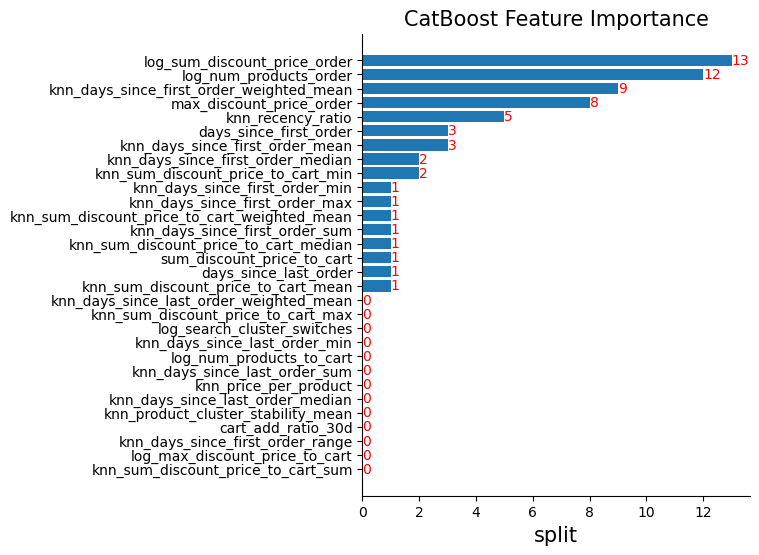

In [ ]:
from local_utils import *

print('feature_importance:', catboost_model.feature_importances_, '\n')

plot_catboost_importance(catboost_model, cols, importance_type='split', top_k=30, sklearn_style=True)

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import optuna
import time
from functools import partial

# Подготовка данных
lgb_tr, lgb_val = get_split(df_pd, val_size=0.25, random_state=41)

def objective_lgbm(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 41,
        'verbose': -1
    }
    
    # Создаем callback для ранней остановки
    callbacks = [
        lgb.early_stopping(stopping_rounds=60, verbose=0),
        lgb.log_evaluation(period=0)
    ]
    
    model = lgb.LGBMClassifier(**params)
    model.fit(
        lgb_tr[cols], lgb_tr['target'],
        eval_set=[(lgb_val[cols], lgb_val['target'])],
        callbacks=callbacks
    )
    
    val_pred = model.predict_proba(lgb_val[cols])[:, 1]
    auc = roc_auc_score(lgb_val['target'], val_pred)
    return auc

# Оптимизация с ограничением времени
study_lgbm = optuna.create_study(direction='maximize')
start_time = time.time()
timeout = 600  # 10 минут в секундах

# Используем partial для передачи timeout в optimize
optimize_func = partial(
    study_lgbm.optimize,
    objective_lgbm,
    n_trials=None,  # Будем продолжать пока не истечет время
    timeout=max(0, timeout - (time.time() - start_time)),
    show_progress_bar=True
)

# Запускаем оптимизацию
optimize_func()

# Лучшая модель LightGBM
best_lgbm_params = study_lgbm.best_params
best_lgbm_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'random_state': 41,
    'verbose': 1
})

# Добавляем callbacks для финального обучения
final_callbacks = [
    lgb.early_stopping(stopping_rounds=60, verbose=1),
    lgb.log_evaluation(period=10),
    # Кастомный callback для записи ROC AUC
    '''lambda env: print(
        f"[{env.iteration}] Train's AUC: {env.evaluation_result_list[0][2]:.4f}, "
        f"Valid's AUC: {env.evaluation_result_list[1][2]:.4f}" 
        if len(env.evaluation_result_list) > 1 
        else f"[{env.iteration}] Train's AUC: {env.evaluation_result_list[0][2]:.4f}"
    )'''
]


lgb_model = lgb.LGBMClassifier(**best_lgbm_params)
lgb_model.fit(
    pd.concat([lgb_tr, lgb_val])[cols], 
    pd.concat([lgb_tr, lgb_val])['target'],
    eval_set=[(lgb_val[cols], lgb_val['target'])],
    callbacks=final_callbacks
)

NameError: name 'get_split' is not defined

feature_importance: [1307 4070 4475 2429  669 1314 3521 1970 1913 1936 1744 1902 2072  511
 6170 4359 4485  296  970 3419  775 1286 1040 4055 2424 1904 1282 2060
 1904  984 3779 3398 3159 2542 4650 1931 1258 3216  825 1137 3595 1150
 1303 2672 1025 1806  810  255 4137 1261  590 2355  851  671  556  239
 1215  552 1429 1602 2833 3695  572  966  739 1018  954 2429  195   62
 2156  491 1247 1253  155 1436 1337  708  152 1698 3395 2417 2974 2927
 2786    4 2034  158   81 1608 1731  739 1486  868  667 1874 4749  803
  229   82 2364 5382 5052 1594    0 1389  783 1754  811 1746 5010 3180
 2854 1228  401 1899 1183 1396 3529 2437 4874 4828  558 2315] 



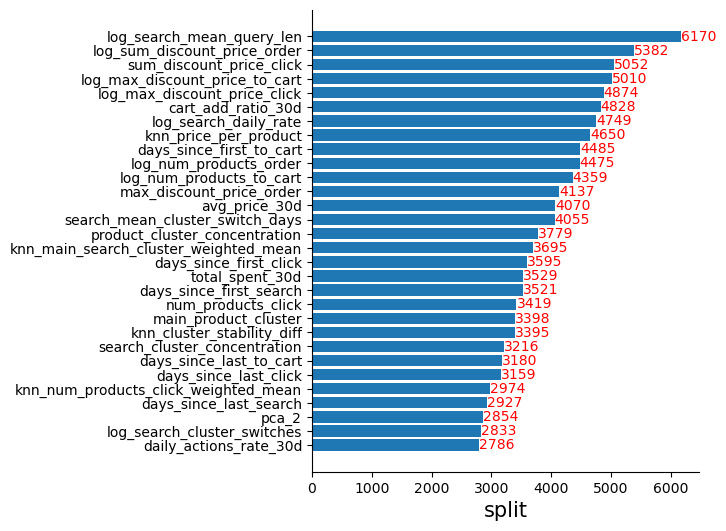

In [ ]:
from local_utils import *

print('feature_importance:', lgb_model.feature_importances_, '\n')

plot_lgbm_importance(lgb_model, cols, importance_type='split', top_k=30, sklearn_style=True)

In [23]:
from local_utils import *

tr_simple, val_simple = get_split(df_pd, val_size=0.20, random_state=23)

cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

# Параметры CatBoost (аналогичные вашим LGBM параметрам)
params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': 0.01,
    'depth': 10,  # Аналог max_depth в LGBM
    'iterations': 900,
    'early_stopping_rounds': 60,
    'verbose': 1,
    'random_seed': 42,
    'thread_count': -1,  # Использовать все ядра
    'grow_policy': 'Lossguide', # Более быстрый режим роста
}

catboost_model_simple = train_catboost_model(tr_simple, val_simple, cols, 'target', params=params, shadow_features=False, sklearn_style=True)

0:	test: 0.7386670	best: 0.7386670 (0)	total: 522ms	remaining: 7m 49s
100:	test: 0.7520092	best: 0.7522564 (93)	total: 40.2s	remaining: 5m 18s
200:	test: 0.7565732	best: 0.7565732 (200)	total: 1m 22s	remaining: 4m 45s
300:	test: 0.7585531	best: 0.7585531 (300)	total: 2m 8s	remaining: 4m 16s
400:	test: 0.7594198	best: 0.7594198 (400)	total: 2m 58s	remaining: 3m 41s
500:	test: 0.7599608	best: 0.7599608 (500)	total: 3m 51s	remaining: 3m 3s
600:	test: 0.7602458	best: 0.7602580 (599)	total: 4m 49s	remaining: 2m 24s
700:	test: 0.7604845	best: 0.7604845 (699)	total: 5m 49s	remaining: 1m 39s
800:	test: 0.7606683	best: 0.7606815 (799)	total: 6m 49s	remaining: 50.7s
899:	test: 0.7608537	best: 0.7608793 (892)	total: 7m 48s	remaining: 0us

bestTest = 0.7608792535
bestIteration = 892

Shrink model to first 893 iterations.


In [ ]:
from local_utils import *

df_pd = df_pd[df_pd['user_id'] != 2346229]

lgb_tr, lgb_val = get_split(df_pd, val_size=0.25, random_state=41)

cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                  'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                  'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.01,    # Можно уменьшить до 0.005 для большей точности
    
    'max_depth': 120,
    'num_leaves': 75,
    'min_data_in_leaf': 30,
    
    # Настройки обучения
    'num_iterations': 900,    # Можно увеличить при ранней остановке
    'early_stopping_rounds': 60,
    'seed': 42,               # Для воспроизводимости
    
    # Дополнительно
    'verbose': 1,
    'importance_type': 'split',
}

lgb_model = train_model(lgb_tr, lgb_val, cols, 'target', params=lgb_params, shadow_features=False, sklearn_style=True)


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Number of positive: 486153, number of negative: 920063
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24841
[LightGBM] [Info] Number of data points in the train set: 1406216, number of used features: 124
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60


feature_importance: [1420  186  339  155  287  359  395  655  120  445  356  270  293  286
  434  218 1649  177  126  319  290  221  156  101  305  667  235  153
 2526  515 1086  206  680 1377  115  144   39  111    0   52 1037  486
 2351  609  807  761  838  212  233  783   25    0  655 1051  286  314
  286  779   62  875  563  312 1731  513  290  381   75 1014  175    5
  777  728  357 1064 1373  271  422  833  109    8  215    0 1679  651
  576  521 1339   26 1485 1504 1126 1962  392  274  284  170  510  475
  314  302  267  426  163  728    0  566 1578  369  171  960  939    0
  772  415  198 1248  623  813  773  182  157    5    0   79] 



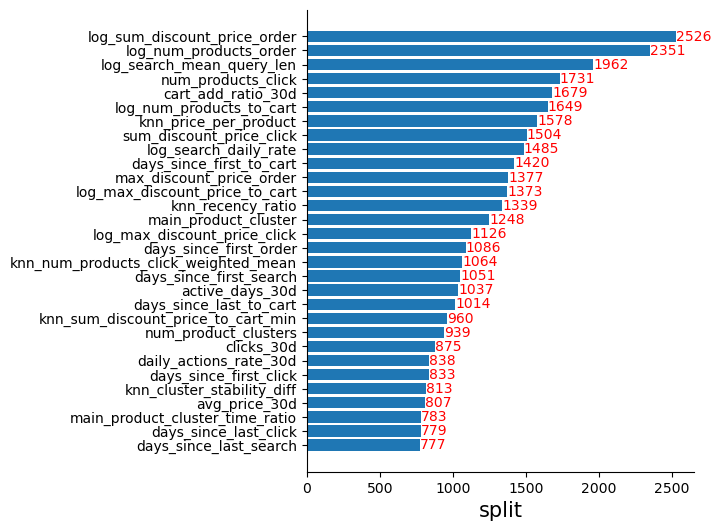

In [28]:
from local_utils import *

print('feature_importance:', lgb_model.feature_importances_, '\n')

plot_lgbm_importance(lgb_model, cols, importance_type='split', top_k=30, sklearn_style=True)

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

In [34]:
#test_df_pd['catboost_predict'] = catboost_model_simple.predict_proba(test_df_pd[cols])[:, 1]
#test_df_pd['lgb_predict'] = lgb_model.predict_proba(test_df_pd[cols])[:, 1]

test_df_pd['predict'] = lgb_model.predict_proba(test_df_pd[cols])[:, 1]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


In [ ]:
test_df_pd['predict'] = test_df_pd[['catboost_predict', 'lgb_predict']].mean(axis=1)

In [35]:
#test_df_pd[['user_id', 'catboost_predict', 'lgb_predict', 'predict']]
test_df_pd[['user_id', 'predict']]

,user_id,predict
0,1342,0.172848
1,9852,0.789371
2,10206,0.226974
3,11317,0.233373
4,13289,0.669969
...,...,...
2068419,11157283,0.201474
2068420,11160395,0.144858
2068421,11165052,0.593451
2068422,11168218,0.544563


In [36]:
test_df_pd[['user_id', 'predict']].to_csv('best_lgbm.csv', index=False)